COMMODITY SEASONALITY ANALYSIS - VERSIONE CORRETTA

[1/6] Download dati...
Download dati: 2005-11-27 → 2025-12-07 ...

[2/6] Calcolo rendimenti mensili...

[3/6] Analisi stagionalita e Top/Bottom 3 per mese...

RENDIMENTI MEDI MENSILI (%) - ULTIMI 20 ANNI
     WTI Crude  Brent Crude  Natural Gas  RBOB Gasoline  Heating Oil  Gold  Silver  Platinum  Palladium  Copper  Corn  Wheat  KC Wheat  Soybeans  Soybean Meal  Soybean Oil  Oats  Coffee  Cocoa  Cotton  Sugar #11  Orange Juice  Live Cattle  Feeder Cattle  Lean Hogs  Lumber  Class III Milk  All (avg)
Jan       0.64         1.37        -3.20           1.33         1.52  3.55    4.34      4.19       1.85    0.55  1.33  -1.38     -0.22      0.87          0.12         1.15  0.63    2.54   1.28    2.10       3.18         -0.09        -0.10          -1.14      -0.69    0.48           -0.92       0.94
Feb       2.78         4.24        -3.68           4.95         0.35  0.86    1.57      0.19       1.32    3.17  1.05   0.23      1.28      1.16

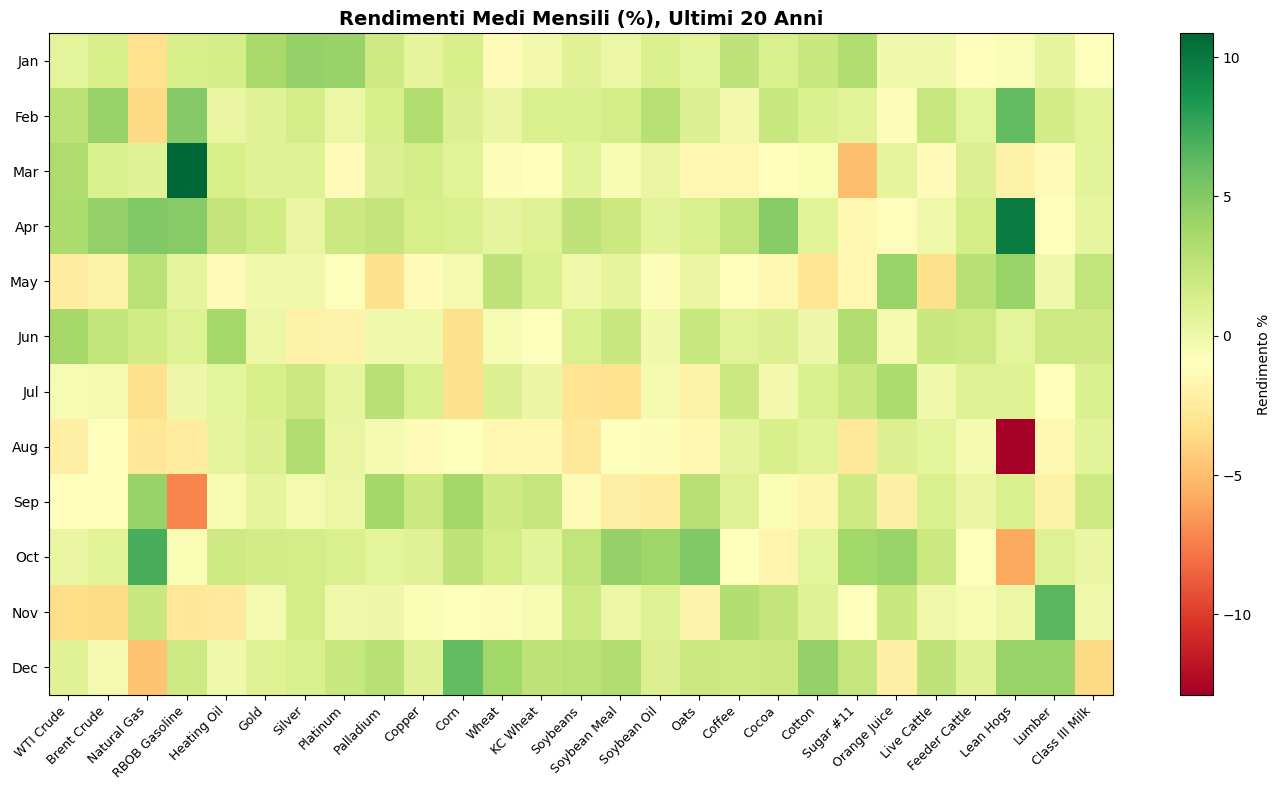


[4/6] Test di ipotesi sulla stagionalita...

  Risultati T-test (H0: rendimento medio = 0):
  - Test totali: 324
  - Significativi al 5%: 38 (11.7%)

  Dettaglio mesi/asset con rendimento significativamente diverso da zero:
----------------------------------------------------------------------
         Asset Month  Mean_Return_%    T_Stat      P_Value
     Lean Hogs   Aug     -12.875492 -8.883433 8.524237e-08
 RBOB Gasoline   Mar      10.846904  8.529560 2.390971e-07
     Lean Hogs   Apr       9.817691  4.567624 2.103318e-04
   Live Cattle   Dec       2.585284  4.433119 2.556801e-04
          Corn   Dec       6.125260  4.076536 5.882332e-04
 RBOB Gasoline   Sep      -7.189240 -3.652313 1.694185e-03
          Gold   Jan       3.548519  3.395673 3.034014e-03
     Lean Hogs   Feb       6.201955  3.048423 6.612074e-03
   Soybean Oil   Oct       3.961317  3.032194 7.165260e-03
      Platinum   Jan       4.192737  2.994719 7.448287e-03
        Cotton   Dec       4.364421  2.952540 7.872078e

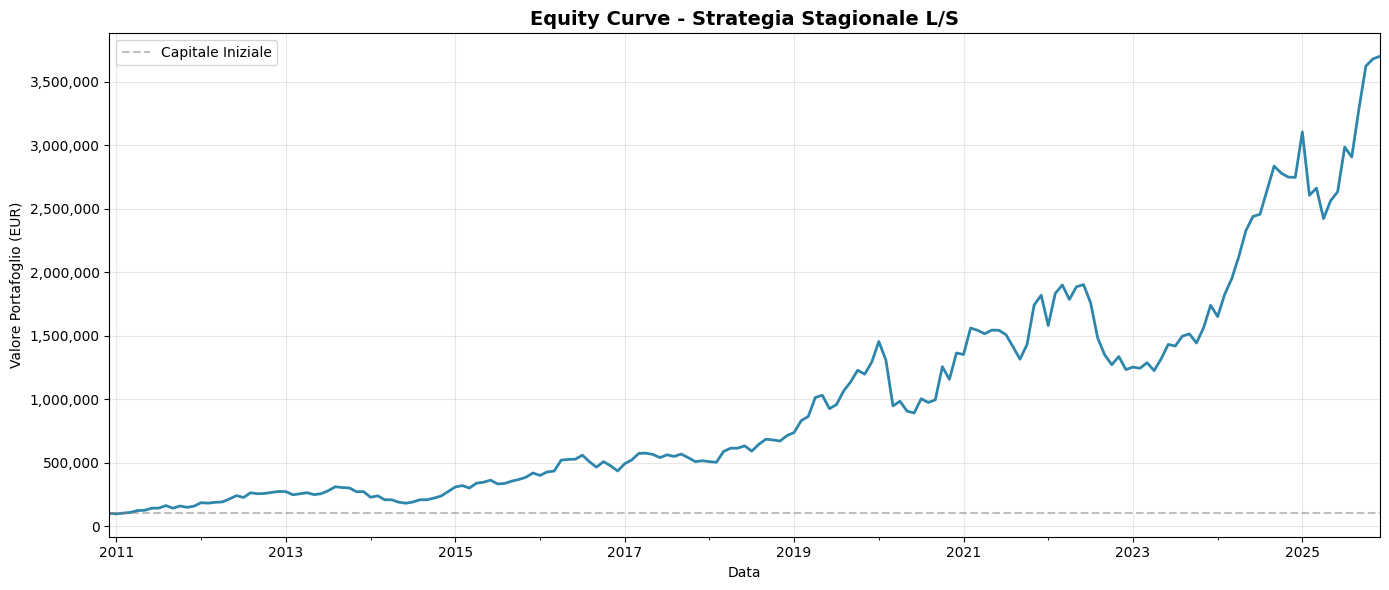

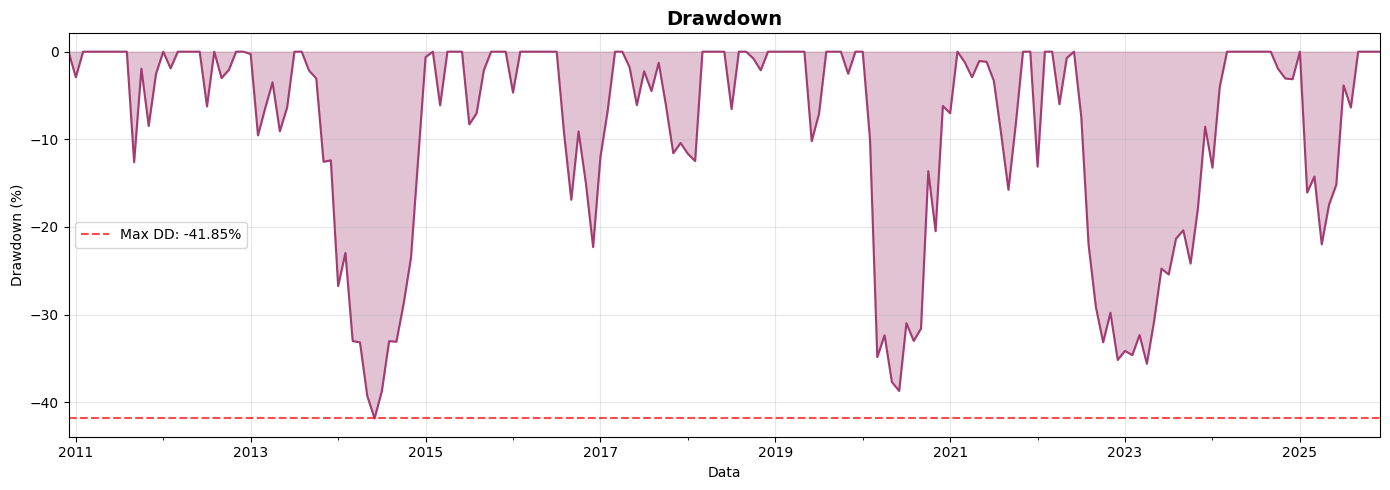

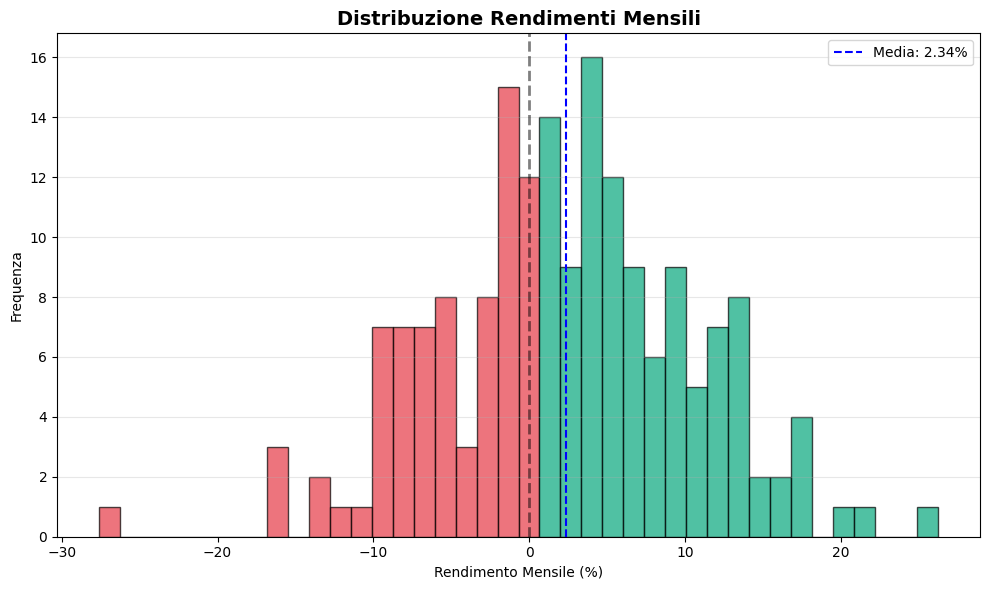

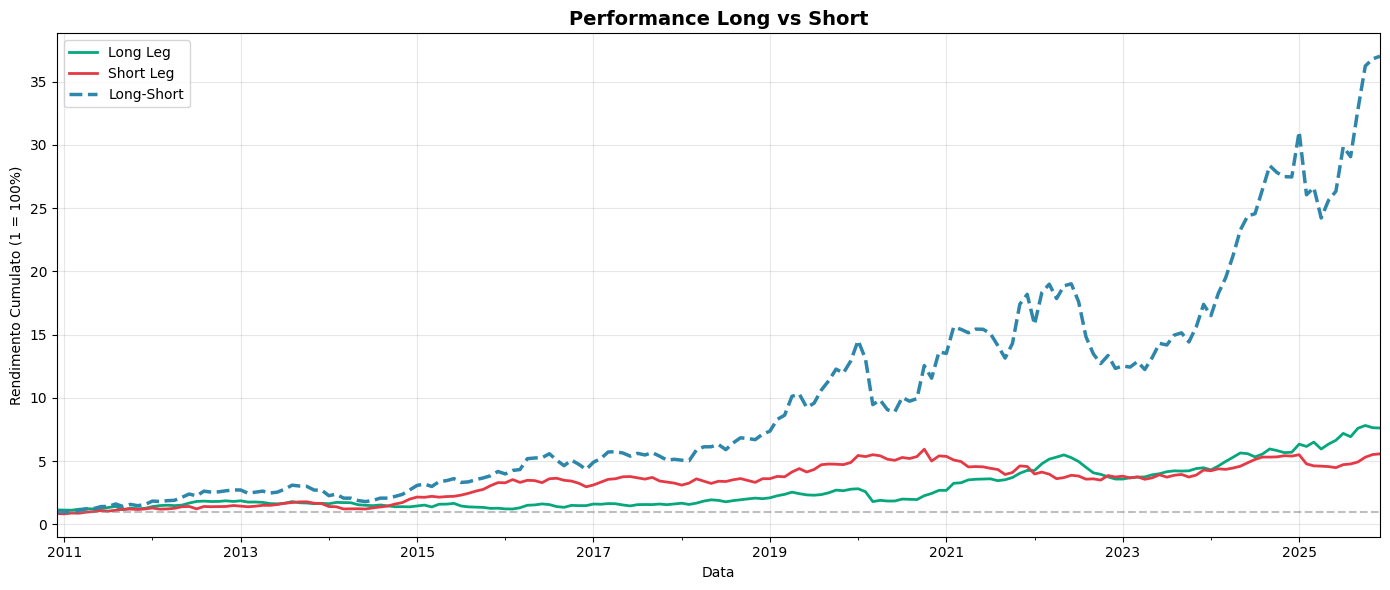

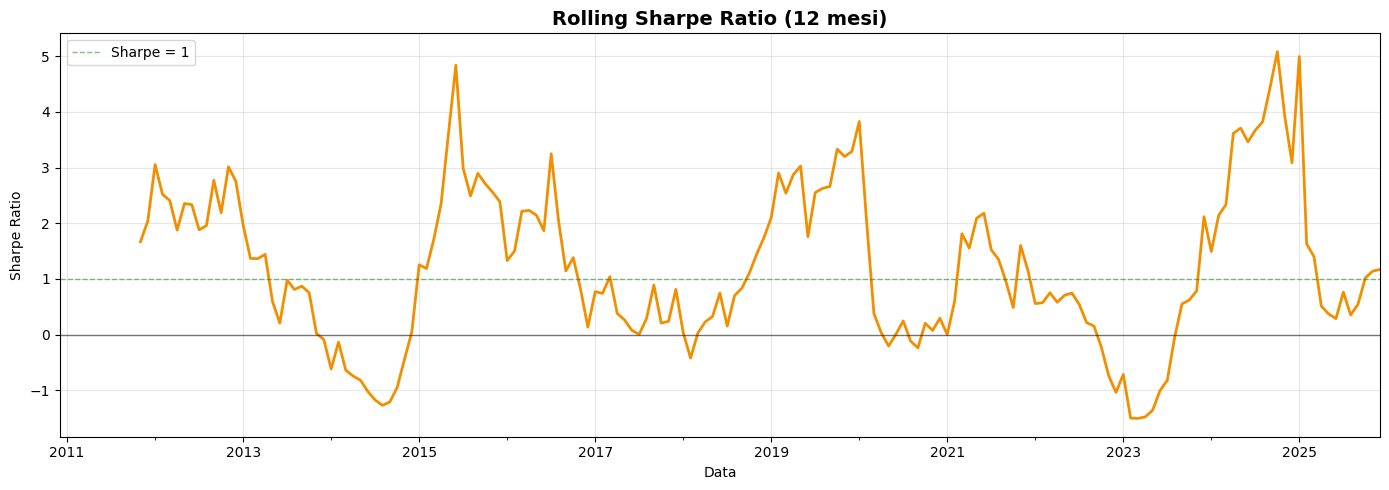

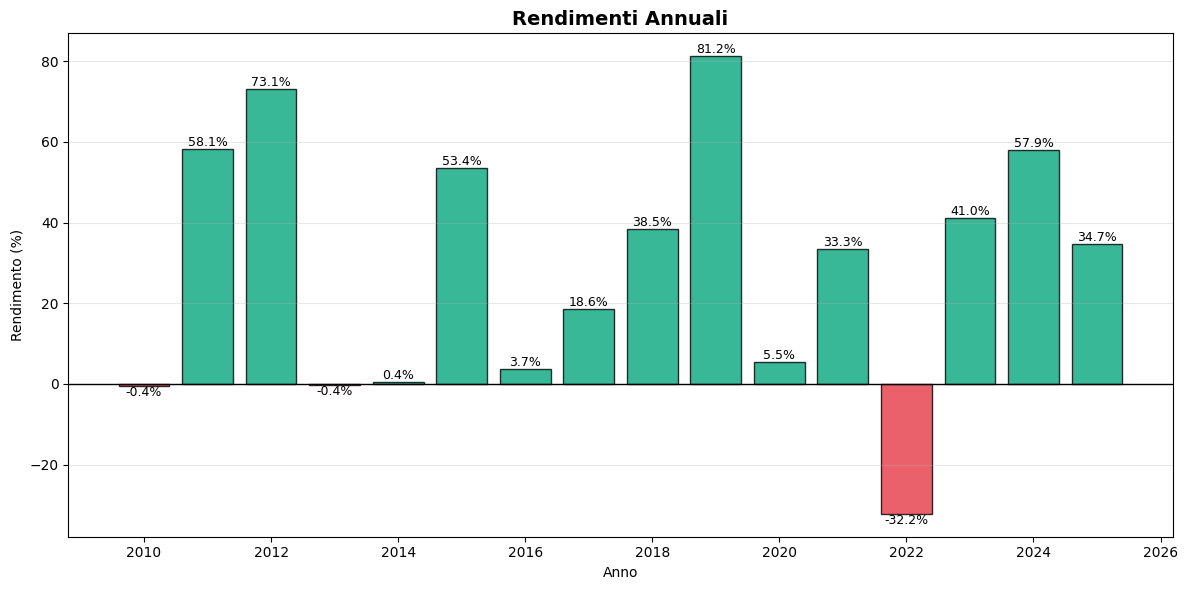


INTERPRETAZIONE DEI RISULTATI
  [OK] La strategia genera rendimenti STATISTICAMENTE SIGNIFICATIVI
  [OK] Lo Sharpe Ratio e significativamente maggiore di zero
  --> La stagionalita nelle commodity sembra essere un effetto reale

  [!!] Solo il 22% degli asset mostra stagionalita significativa

ANALISI COMPLETATA


In [1]:
# -*- coding: utf-8 -*-
"""
Commodity Seasonality Analysis
Analisi stagionalita mensile su commodity futures con:
1) Top 3 e Bottom 3 per ogni mese (statisticamente)
2) Calcoli corretti di Sharpe, Sortino, rendimenti
3) Test di ipotesi per validare la significativita statistica
"""

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.ion()

TICKERS = {
    # Energy
    "WTI Crude": "CL=F", "Brent Crude": "BZ=F", "Natural Gas": "NG=F",
    "RBOB Gasoline": "RB=F", "Heating Oil": "HO=F",
    # Precious & Industrial Metals
    "Gold": "GC=F", "Silver": "SI=F", "Platinum": "PL=F", "Palladium": "PA=F",
    "Copper": "HG=F",
    # Grains & Oilseeds
    "Corn": "ZC=F", "Wheat": "ZW=F", "KC Wheat": "KE=F", "Soybeans": "ZS=F",
    "Soybean Meal": "ZM=F", "Soybean Oil": "ZL=F", "Oats": "ZO=F",
    # Softs
    "Coffee": "KC=F", "Cocoa": "CC=F", "Cotton": "CT=F", "Sugar #11": "SB=F",
    "Orange Juice": "OJ=F",
    # Livestock
    "Live Cattle": "LE=F", "Feeder Cattle": "GF=F", "Lean Hogs": "HE=F",
    # Forest & Others
    "Lumber": "LBS=F", "Class III Milk": "DC=F",
}

# Parametri temporali
today = datetime.today().date()
start_date = today - timedelta(days=365*20 + 15)
end_date = today

# Parametri outlier
OUTLIER_METHOD = "drop"
LOW_Q, HIGH_Q = 0.01, 0.99
MIN_OBS_MONTHLY = 36

# Parametri backtest
TOP_K = 3
MIN_OBS_PER_MONTH = 5
SLIPPAGE_BPS = 5.0  # 5 bps piu realistico
INITIAL_CAPITAL = 100_000.0
RISK_FREE = 0.04  # 4% annuo



def extract_close(df, yfin_ticker, friendly_name):
    """Estrae la serie dei prezzi di chiusura."""
    if df is None or df.empty:
        return None
    if isinstance(df.columns, pd.MultiIndex):
        if yfin_ticker not in df.columns.get_level_values(0):
            return None
        sub = df[yfin_ticker]
        col = "Adj Close" if "Adj Close" in sub.columns else ("Close" if "Close" in sub.columns else None)
        return sub[col].rename(friendly_name) if col else None
    cols = df.columns
    col = "Adj Close" if "Adj Close" in cols else ("Close" if "Close" in cols else None)
    return df[col].rename(friendly_name) if col else None


def download_prices(ticker_map, start, end):
    """Scarica i prezzi da Yahoo Finance."""
    print(f"Download dati: {start} → {end} ...")
    batch = yf.download(
        tickers=list(ticker_map.values()),
        start=start.isoformat(),
        end=end.isoformat(),
        auto_adjust=False,
        progress=False,
        group_by="ticker",
        threads=True,
    )

    series_list, missing = [], []
    for name, t in ticker_map.items():
        s = extract_close(batch, t, name)
        if s is None or s.dropna().empty:
            missing.append((name, t))
        else:
            series_list.append(s)

    # Fallback per ticker mancanti
    for name, t in missing:
        try:
            import time
            time.sleep(0.2)
            hist = yf.Ticker(t).history(start=start.isoformat(), end=end.isoformat())
            s = extract_close(hist, t, name)
            if s is not None and not s.dropna().empty:
                series_list.append(s)
            else:
                print(f"  [!] Nessun dato per {name} ({t})")
        except Exception as e:
            print(f"  [!] Errore per {name} ({t}): {e}")

    if not series_list:
        raise RuntimeError("Download fallito: nessuna serie valida.")

    return pd.concat(series_list, axis=1).sort_index()

# FUNZIONI OUTLIER
def handle_outliers(ret_df, method="drop", low_q=0.01, high_q=0.99):
    """Gestisce gli outlier per asset."""
    cleaned = ret_df.copy()
    for col in cleaned.columns:
        s = cleaned[col].dropna()
        if s.empty:
            continue
        q_low = s.quantile(low_q)
        q_high = s.quantile(high_q)
        if method == "drop":
            mask = (cleaned[col] < q_low) | (cleaned[col] > q_high)
            cleaned.loc[mask, col] = np.nan
        elif method == "winsor":
            cleaned[col] = np.clip(cleaned[col], q_low, q_high)
    return cleaned

# FUNZIONI STATISTICHE CORRETTE
def compound_annual_return(monthly_returns):
    """Calcola il rendimento annualizzato composto."""
    if monthly_returns.dropna().empty:
        return np.nan
    mean_m = monthly_returns.mean()
    return (1 + mean_m) ** 12 - 1


def annualized_volatility(monthly_returns):
    """Calcola la volatilità annualizzata."""
    if monthly_returns.dropna().empty:
        return np.nan
    return monthly_returns.std() * np.sqrt(12)


def sharpe_ratio(monthly_returns, rf_annual=0.04):
    """
    Sharpe Ratio CORRETTO:
    SR = (Rendimento annualizzato composto - RF) / Volatilità annualizzata
    """
    ann_ret = compound_annual_return(monthly_returns)
    ann_vol = annualized_volatility(monthly_returns)
    if pd.isna(ann_ret) or pd.isna(ann_vol) or ann_vol == 0:
        return np.nan
    return (ann_ret - rf_annual) / ann_vol


def sortino_ratio(monthly_returns, rf_annual=0.04, mar=0.0):
    """
    Sortino Ratio CORRETTO:
    Usa MAR (Minimum Acceptable Return) come soglia, tipicamente 0.
    SR = (Rendimento annualizzato - RF) / Downside Deviation annualizzata
    """
    ann_ret = compound_annual_return(monthly_returns)
    # Downside deviation: deviazione standard dei rendimenti sotto MAR
    downside_returns = monthly_returns[monthly_returns < mar]
    if downside_returns.empty:
        return np.nan
    downside_dev = downside_returns.std() * np.sqrt(12)
    if pd.isna(ann_ret) or pd.isna(downside_dev) or downside_dev == 0:
        return np.nan
    return (ann_ret - rf_annual) / downside_dev


def calmar_ratio(monthly_returns, rf_annual=0.04):
    """Calmar Ratio = CAGR / |Max Drawdown|"""
    equity = (1 + monthly_returns).cumprod()
    roll_max = equity.cummax()
    drawdown = (equity - roll_max) / roll_max
    max_dd = drawdown.min()

    if pd.isna(max_dd) or max_dd >= 0:
        return np.nan

    cagr = compound_annual_return(monthly_returns)
    return cagr / abs(max_dd)


def calculate_all_metrics(monthly_returns, rf_annual=0.04, initial_capital=100000):
    """Calcola tutte le metriche di portafoglio."""
    if monthly_returns.dropna().empty:
        return {}

    # Equity curve
    equity = (1 + monthly_returns).cumprod() * initial_capital

    # Drawdown
    roll_max = equity.cummax()
    drawdown = (equity - roll_max) / roll_max
    max_dd = drawdown.min()

    # Durata max drawdown
    dd_durations = []
    cur = 0
    for dd in drawdown:
        if dd < 0:
            cur += 1
        else:
            if cur > 0:
                dd_durations.append(cur)
            cur = 0
    if cur > 0:
        dd_durations.append(cur)
    max_dd_len = max(dd_durations) if dd_durations else 0

    # Metriche base
    months = len(monthly_returns)
    years = months / 12.0

    ann_ret = compound_annual_return(monthly_returns)
    ann_vol = annualized_volatility(monthly_returns)

    # CAGR
    end_value = equity.iloc[-1]
    cagr = (end_value / initial_capital) ** (1/years) - 1 if years > 0 else np.nan

    # VaR e ES
    var95 = monthly_returns.quantile(0.05)
    es95 = monthly_returns[monthly_returns <= var95].mean()

    return {
        "Start Date": monthly_returns.index.min().date(),
        "End Date": monthly_returns.index.max().date(),
        "Months": months,
        "Years": round(years, 2),
        "CAGR": cagr,
        "Ann. Return (compound)": ann_ret,
        "Ann. Volatility": ann_vol,
        "Sharpe Ratio": sharpe_ratio(monthly_returns, rf_annual),
        "Sortino Ratio (MAR=0)": sortino_ratio(monthly_returns, rf_annual, mar=0.0),
        "Max Drawdown": max_dd,
        "Max DD Length (months)": max_dd_len,
        "Calmar Ratio": calmar_ratio(monthly_returns, rf_annual),
        "Hit Ratio": (monthly_returns > 0).mean(),
        "Skewness": monthly_returns.skew(),
        "Excess Kurtosis": monthly_returns.kurt(),
        "Best Month": monthly_returns.max(),
        "Worst Month": monthly_returns.min(),
        "VaR 95% (monthly)": var95,
        "ES 95% (monthly)": es95,
        "End Equity": end_value,
    }


# TEST DI IPOTESI
def test_seasonality_significance(monthly_ret_clean, alpha=0.05):
    """
    Test di ipotesi per la significatività della stagionalità.

    Per ogni mese e ogni asset, testiamo:
    H0: rendimento medio del mese = 0
    H1: rendimento medio del mese ≠ 0

    Usiamo anche un test ANOVA per verificare se ci sono differenze
    significative tra i mesi per ogni asset.
    """
    results = []
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for asset in monthly_ret_clean.columns:
        asset_data = monthly_ret_clean[asset].dropna()
        if asset_data.empty:
            continue

        # Raggruppa per mese
        monthly_groups = [asset_data[asset_data.index.month == m] for m in range(1, 13)]

        # T-test per ogni mese (H0: mean = 0)
        for m, group in enumerate(monthly_groups, 1):
            if len(group) < 3:
                continue
            t_stat, p_value = stats.ttest_1samp(group, 0)
            mean_ret = group.mean()
            std_ret = group.std()
            n_obs = len(group)

            # Calcola intervallo di confidenza al 95%
            se = std_ret / np.sqrt(n_obs)
            ci_lower = mean_ret - 1.96 * se
            ci_upper = mean_ret + 1.96 * se

            results.append({
                'Asset': asset,
                'Month': month_names[m-1],
                'Month_Num': m,
                'Mean_Return_%': mean_ret * 100,
                'Std_Dev_%': std_ret * 100,
                'N_Obs': n_obs,
                'T_Stat': t_stat,
                'P_Value': p_value,
                'Significant': p_value < alpha,
                'CI_Lower_%': ci_lower * 100,
                'CI_Upper_%': ci_upper * 100,
            })

        # ANOVA: test se i mesi hanno rendimenti diversi
        valid_groups = [g for g in monthly_groups if len(g) >= 3]
        if len(valid_groups) >= 2:
            f_stat, anova_p = stats.f_oneway(*valid_groups)
            results.append({
                'Asset': asset,
                'Month': 'ANOVA',
                'Month_Num': 0,
                'Mean_Return_%': np.nan,
                'Std_Dev_%': np.nan,
                'N_Obs': sum(len(g) for g in valid_groups),
                'T_Stat': f_stat,
                'P_Value': anova_p,
                'Significant': anova_p < alpha,
                'CI_Lower_%': np.nan,
                'CI_Upper_%': np.nan,
            })

    return pd.DataFrame(results)


def test_strategy_significance(strategy_returns, alpha=0.05):
    """
    Test se la strategia genera rendimenti significativamente diversi da zero.

    Eseguiamo:
    1. T-test sui rendimenti mensili (H0: mean = 0)
    2. Bootstrap per stimare l'intervallo di confidenza dello Sharpe Ratio
    3. Test di autocorrelazione (Ljung-Box)
    """
    results = {}

    # 1. T-test sui rendimenti
    t_stat, p_value = stats.ttest_1samp(strategy_returns.dropna(), 0)
    results['t_test'] = {
        'statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'mean_return': strategy_returns.mean(),
        'std_error': strategy_returns.std() / np.sqrt(len(strategy_returns)),
    }

    # 2. Bootstrap per Sharpe Ratio
    n_bootstrap = 10000
    sharpe_estimates = []
    n = len(strategy_returns)

    np.random.seed(42)
    for _ in range(n_bootstrap):
        sample = strategy_returns.sample(n=n, replace=True)
        sr = sharpe_ratio(sample, RISK_FREE)
        if not np.isnan(sr):
            sharpe_estimates.append(sr)

    sharpe_estimates = np.array(sharpe_estimates)
    original_sharpe = sharpe_ratio(strategy_returns, RISK_FREE)

    # Intervallo di confidenza bootstrap (percentile method)
    ci_lower = np.percentile(sharpe_estimates, 2.5)
    ci_upper = np.percentile(sharpe_estimates, 97.5)

    # Lo Sharpe è significativamente > 0 se il CI non include 0
    sharpe_significant = ci_lower > 0

    results['sharpe_bootstrap'] = {
        'sharpe_ratio': original_sharpe,
        'ci_lower_95': ci_lower,
        'ci_upper_95': ci_upper,
        'std_error': sharpe_estimates.std(),
        'significant': sharpe_significant,
        'p_value_approx': (sharpe_estimates <= 0).mean(),  # Approssimazione del p-value
    }

    # 3. Test autocorrelazione (i rendimenti dovrebbero essere indipendenti)
    from scipy.stats import pearsonr
    if len(strategy_returns) > 2:
        autocorr_1, autocorr_p = pearsonr(strategy_returns.iloc[:-1], strategy_returns.iloc[1:])
        results['autocorrelation'] = {
            'lag1_correlation': autocorr_1,
            'p_value': autocorr_p,
            'independent': autocorr_p > alpha,  # Non significativo = buono
        }

    return results

# ANALISI TOP 3 / BOTTOM 3 PER MESE
def analyze_monthly_rankings(monthly_ret_clean):
    """
    Crea una tabella con le Top 3 e Bottom 3 commodity per ogni mese,
    includendo statistiche e test di significatività.
    """
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Calcola medie e statistiche per ogni mese/asset
    results = []

    for month_num in range(1, 13):
        month_data = monthly_ret_clean[monthly_ret_clean.index.month == month_num]

        for asset in monthly_ret_clean.columns:
            asset_month = month_data[asset].dropna()
            if len(asset_month) < 3:
                continue

            mean_ret = asset_month.mean()
            std_ret = asset_month.std()
            n_obs = len(asset_month)
            se = std_ret / np.sqrt(n_obs)

            # T-test
            t_stat, p_value = stats.ttest_1samp(asset_month, 0)

            results.append({
                'Month': month_names[month_num - 1],
                'Month_Num': month_num,
                'Asset': asset,
                'Mean_Return_%': mean_ret * 100,
                'Std_Dev_%': std_ret * 100,
                'N_Obs': n_obs,
                'T_Stat': t_stat,
                'P_Value': p_value,
                'Significant_5%': p_value < 0.05,
                'SE': se * 100,
            })

    df = pd.DataFrame(results)

    # Per ogni mese, identifica Top 3 e Bottom 3
    rankings = []
    for month_num in range(1, 13):
        month_df = df[df['Month_Num'] == month_num].copy()
        if month_df.empty:
            continue

        # Ordina per rendimento medio
        month_df_sorted = month_df.sort_values('Mean_Return_%', ascending=False)

        # Top 3
        top3 = month_df_sorted.head(3).copy()
        top3['Rank'] = ['Top 1', 'Top 2', 'Top 3'][:len(top3)]
        top3['Category'] = 'TOP'

        # Bottom 3
        bot3 = month_df_sorted.tail(3).iloc[::-1].copy()  # Inverti per avere il peggiore primo
        bot3['Rank'] = ['Bottom 1', 'Bottom 2', 'Bottom 3'][:len(bot3)]
        bot3['Category'] = 'BOTTOM'

        rankings.append(top3)
        rankings.append(bot3)

    rankings_df = pd.concat(rankings, ignore_index=True)

    return df, rankings_df


def create_summary_table(monthly_ret_clean):
    """
    Crea una tabella riassuntiva compatta: per ogni mese mostra Top 3 e Bottom 3.
    """
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    summary = []

    for month_num in range(1, 13):
        month_data = monthly_ret_clean[monthly_ret_clean.index.month == month_num]

        # Calcola media per ogni asset
        means = month_data.mean().sort_values(ascending=False)

        # Top 3
        top3 = means.head(3)
        top3_str = ", ".join([f"{name} ({ret*100:.2f}%)" for name, ret in top3.items()])

        # Bottom 3
        bot3 = means.tail(3).sort_values()
        bot3_str = ", ".join([f"{name} ({ret*100:.2f}%)" for name, ret in bot3.items()])

        # Calcola significatività per top e bottom
        top_signif = []
        for asset in top3.index:
            asset_month = month_data[asset].dropna()
            if len(asset_month) >= 3:
                _, p = stats.ttest_1samp(asset_month, 0)
                top_signif.append('*' if p < 0.05 else '')
            else:
                top_signif.append('')

        bot_signif = []
        for asset in bot3.index:
            asset_month = month_data[asset].dropna()
            if len(asset_month) >= 3:
                _, p = stats.ttest_1samp(asset_month, 0)
                bot_signif.append('*' if p < 0.05 else '')
            else:
                bot_signif.append('')

        summary.append({
            'Month': month_names[month_num - 1],
            'Top_1': f"{top3.index[0]} ({top3.iloc[0]*100:.2f}%){top_signif[0]}",
            'Top_2': f"{top3.index[1]} ({top3.iloc[1]*100:.2f}%){top_signif[1]}" if len(top3) > 1 else "",
            'Top_3': f"{top3.index[2]} ({top3.iloc[2]*100:.2f}%){top_signif[2]}" if len(top3) > 2 else "",
            'Bottom_1': f"{bot3.index[0]} ({bot3.iloc[0]*100:.2f}%){bot_signif[0]}",
            'Bottom_2': f"{bot3.index[1]} ({bot3.iloc[1]*100:.2f}%){bot_signif[1]}" if len(bot3) > 1 else "",
            'Bottom_3': f"{bot3.index[2]} ({bot3.iloc[2]*100:.2f}%){bot_signif[2]}" if len(bot3) > 2 else "",
        })

    return pd.DataFrame(summary)


# BACKTEST WALK-FORWARD
def run_seasonality_backtest(monthly_ret_clean, top_k=3, min_obs=5, slippage_bps=5.0):
    """
    Backtest walk-forward della strategia Long/Short stagionale.
    """
    rets = monthly_ret_clean.copy()
    all_months = rets.index

    ls_port_ret = pd.Series(index=rets.index, dtype=float)
    long_leg_ret = pd.Series(index=rets.index, dtype=float)
    short_leg_ret = pd.Series(index=rets.index, dtype=float)
    selected_long = {}
    selected_short = {}

    for t in range(1, len(all_months)):
        date_t = all_months[t]
        month_num = date_t.month

        # Finestra di training: tutti i mesi < date_t con lo stesso numero di mese
        hist_mask = (rets.index < date_t) & (rets.index.month == month_num)
        hist = rets.loc[hist_mask]

        if hist.shape[0] == 0:
            continue

        # Conta osservazioni valide per asset
        valid_counts = hist.notna().sum(axis=0)
        allowed_assets = valid_counts[valid_counts >= min_obs].index.tolist()

        if len(allowed_assets) < 2 * top_k:
            continue

        # Media storica per asset
        hist_means = hist[allowed_assets].mean(axis=0)

        # Ranking
        top_assets = hist_means.sort_values(ascending=False).head(top_k).index.tolist()
        bot_assets = hist_means.sort_values(ascending=True).head(top_k).index.tolist()

        # Rendimento del mese corrente
        month_ret = rets.loc[date_t]

        # Filtra asset disponibili
        top_avail = [a for a in top_assets if pd.notna(month_ret.get(a, np.nan))]
        bot_avail = [a for a in bot_assets if pd.notna(month_ret.get(a, np.nan))]

        if len(top_avail) == 0 or len(bot_avail) == 0:
            continue

        # Pesi equal-weight
        w_long = {a: 1.0 / len(top_avail) for a in top_avail}
        w_short = {a: -1.0 / len(bot_avail) for a in bot_avail}

        # Calcola rendimenti
        long_r = sum(w_long[a] * month_ret[a] for a in top_avail)
        short_r = sum(w_short[a] * month_ret[a] for a in bot_avail)
        gross_ls = long_r + short_r

        # Costi/slippage
        if slippage_bps > 0:
            cost_long = slippage_bps * 1e-4 * sum(abs(w) for w in w_long.values())
            cost_short = slippage_bps * 1e-4 * sum(abs(w) for w in w_short.values())
            gross_ls -= (cost_long + cost_short)

        ls_port_ret.loc[date_t] = gross_ls
        long_leg_ret.loc[date_t] = long_r
        short_leg_ret.loc[date_t] = short_r
        selected_long[date_t] = top_avail
        selected_short[date_t] = bot_avail

    # Drop mesi non valorizzati
    ls_port_ret = ls_port_ret.dropna()
    long_leg_ret = long_leg_ret.dropna()
    short_leg_ret = short_leg_ret.dropna()

    return ls_port_ret, long_leg_ret, short_leg_ret, selected_long, selected_short

# VISUALIZZAZIONI
def plot_monthly_heatmap(avg_by_month):
    """Heatmap dei rendimenti medi mensili."""
    fig, ax = plt.subplots(figsize=(14, 8))

    # Prepara dati (escludi colonna 'All (avg)' se presente)
    plot_data = avg_by_month.drop(columns=['All (avg)'], errors='ignore')

    im = ax.imshow(plot_data.values, aspect='auto', cmap='RdYlGn')

    ax.set_xticks(range(len(plot_data.columns)))
    ax.set_xticklabels(list(plot_data.columns), rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(plot_data.index)))
    ax.set_yticklabels(list(plot_data.index))

    ax.set_title("Rendimenti Medi Mensili (%), Ultimi 20 Anni", fontsize=14, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Rendimento %")

    plt.tight_layout()
    plt.show()


def plot_backtest_results(ls_port_ret, long_leg_ret, short_leg_ret, initial_capital=100000):
    """Genera tutti i grafici del backtest e li mostra a schermo."""

    # 1. Equity Curve
    equity = (1 + ls_port_ret).cumprod() * initial_capital

    fig, ax = plt.subplots(figsize=(14, 6))
    equity.plot(ax=ax, linewidth=2, color='#2E86AB')
    ax.set_title("Equity Curve - Strategia Stagionale L/S", fontsize=14, fontweight='bold')
    ax.set_ylabel("Valore Portafoglio (EUR)")
    ax.set_xlabel("Data")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.5, label='Capitale Iniziale')
    ax.legend()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    # 2. Drawdown
    roll_max = equity.cummax()
    drawdown = (equity - roll_max) / roll_max

    fig, ax = plt.subplots(figsize=(14, 5))
    (drawdown * 100).plot(ax=ax, linewidth=1.5, color='#A23B72')
    ax.fill_between(drawdown.index, drawdown * 100, 0, alpha=0.3, color='#A23B72')
    ax.set_title("Drawdown", fontsize=14, fontweight='bold')
    ax.set_ylabel("Drawdown (%)")
    ax.set_xlabel("Data")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=drawdown.min() * 100, color='red', linestyle='--', alpha=0.7,
               label=f'Max DD: {drawdown.min()*100:.2f}%')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 3. Distribuzione rendimenti
    fig, ax = plt.subplots(figsize=(10, 6))
    returns_pct = ls_port_ret * 100
    n, bins, patches = ax.hist(returns_pct, bins=40, edgecolor='black', alpha=0.7)

    for i, patch in enumerate(patches):
        if bins[i] < 0:
            patch.set_facecolor('#E63946')
        else:
            patch.set_facecolor('#06A77D')

    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax.axvline(x=returns_pct.mean(), color='blue', linestyle='--', linewidth=1.5,
               label=f'Media: {returns_pct.mean():.2f}%')
    ax.set_title("Distribuzione Rendimenti Mensili", fontsize=14, fontweight='bold')
    ax.set_xlabel("Rendimento Mensile (%)")
    ax.set_ylabel("Frequenza")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # 4. Long vs Short
    fig, ax = plt.subplots(figsize=(14, 6))
    long_cum = (1 + long_leg_ret).cumprod()
    short_cum = (1 + short_leg_ret).cumprod()
    ls_cum = (1 + ls_port_ret).cumprod()

    long_cum.plot(ax=ax, label='Long Leg', linewidth=2, color='#06A77D')
    short_cum.plot(ax=ax, label='Short Leg', linewidth=2, color='#E63946')
    ls_cum.plot(ax=ax, label='Long-Short', linewidth=2.5, color='#2E86AB', linestyle='--')

    ax.set_title("Performance Long vs Short", fontsize=14, fontweight='bold')
    ax.set_ylabel("Rendimento Cumulato (1 = 100%)")
    ax.set_xlabel("Data")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 5. Rolling Sharpe
    fig, ax = plt.subplots(figsize=(14, 5))
    rolling_window = 12
    rolling_mean = ls_port_ret.rolling(rolling_window).apply(compound_annual_return)
    rolling_vol = ls_port_ret.rolling(rolling_window).apply(annualized_volatility)
    rolling_sharpe = (rolling_mean - RISK_FREE) / rolling_vol

    rolling_sharpe.plot(ax=ax, linewidth=2, color='#F18F01')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = 1')
    ax.set_title(f"Rolling Sharpe Ratio ({rolling_window} mesi)", fontsize=14, fontweight='bold')
    ax.set_ylabel("Sharpe Ratio")
    ax.set_xlabel("Data")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 6. Rendimenti annuali
    annual_returns = (1 + ls_port_ret).groupby(ls_port_ret.index.year).prod() - 1

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#06A77D' if x > 0 else '#E63946' for x in annual_returns.values]
    bars = ax.bar(annual_returns.index, annual_returns.values * 100, color=colors, edgecolor='black', alpha=0.8)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_title("Rendimenti Annuali", fontsize=14, fontweight='bold')
    ax.set_ylabel("Rendimento (%)")
    ax.set_xlabel("Anno")
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


# MAIN
def main():
    print("=" * 70)
    print("COMMODITY SEASONALITY ANALYSIS - VERSIONE CORRETTA")
    print("=" * 70)

    # 1. Download dati
    print("\n[1/6] Download dati...")
    prices = download_prices(TICKERS, start_date, end_date)

    # 2. Calcolo rendimenti mensili
    print("\n[2/6] Calcolo rendimenti mensili...")
    monthly_close = prices.resample("ME").last()  # 'ME' invece di 'M' deprecated
    monthly_ret = monthly_close.pct_change()

    # Filtra per ultimi 20 anni
    cutoff = pd.Timestamp(today.replace(day=1)) - pd.DateOffset(years=20)
    monthly_ret = monthly_ret.loc[monthly_ret.index >= cutoff]

    # Gestione outlier
    monthly_ret_clean = handle_outliers(monthly_ret, method=OUTLIER_METHOD, low_q=LOW_Q, high_q=HIGH_Q)

    # Drop asset con poche osservazioni
    keep_cols = [c for c in monthly_ret_clean.columns if monthly_ret_clean[c].notna().sum() >= MIN_OBS_MONTHLY]
    dropped = set(monthly_ret_clean.columns) - set(keep_cols)
    for d in dropped:
        print(f"  [!] Rimosso {d}: osservazioni insufficienti")
    monthly_ret_clean = monthly_ret_clean[keep_cols]

    # 3. Analisi stagionalita
    print("\n[3/6] Analisi stagionalita e Top/Bottom 3 per mese...")

    # Medie per mese
    month_num = monthly_ret_clean.index.month
    avg_by_month = (monthly_ret_clean.groupby(month_num).mean() * 100).round(2)
    avg_by_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    avg_by_month["All (avg)"] = avg_by_month.mean(axis=1).round(2)

    # Stampa tabella rendimenti medi
    print("\n" + "=" * 70)
    print("RENDIMENTI MEDI MENSILI (%) - ULTIMI 20 ANNI")
    print("=" * 70)
    print(avg_by_month.to_string())

    # Crea tabelle Top/Bottom
    full_stats_df, rankings_df = analyze_monthly_rankings(monthly_ret_clean)
    summary_table = create_summary_table(monthly_ret_clean)

    print("\n" + "=" * 70)
    print("TOP 3 E BOTTOM 3 COMMODITY PER MESE (* = significativo al 5%)")
    print("=" * 70)
    print(summary_table.to_string(index=False))

    # Mostra heatmap
    print("\n[Visualizzazione Heatmap...]")
    plot_monthly_heatmap(avg_by_month)

    # 4. Test di ipotesi sulla stagionalita
    print("\n[4/6] Test di ipotesi sulla stagionalita...")
    seasonality_tests = test_seasonality_significance(monthly_ret_clean)

    # Conta quanti mesi/asset sono significativi
    monthly_tests = seasonality_tests[seasonality_tests['Month'] != 'ANOVA']
    n_significant = monthly_tests['Significant'].sum()
    n_total = len(monthly_tests)

    print(f"\n  Risultati T-test (H0: rendimento medio = 0):")
    print(f"  - Test totali: {n_total}")
    print(f"  - Significativi al 5%: {n_significant} ({n_significant/n_total*100:.1f}%)")

    # Mostra dettaglio test significativi
    significant_tests = monthly_tests[monthly_tests['Significant'] == True].copy()
    if len(significant_tests) > 0:
        print(f"\n  Dettaglio mesi/asset con rendimento significativamente diverso da zero:")
        print("-" * 70)
        sig_display = significant_tests[['Asset', 'Month', 'Mean_Return_%', 'T_Stat', 'P_Value']].copy()
        sig_display = sig_display.sort_values('P_Value')
        print(sig_display.to_string(index=False))

    # ANOVA results
    anova_tests = seasonality_tests[seasonality_tests['Month'] == 'ANOVA']
    n_anova_signif = anova_tests['Significant'].sum()
    n_anova = len(anova_tests)
    print(f"\n  ANOVA (H0: nessuna differenza tra mesi):")
    print(f"  - Asset testati: {n_anova}")
    print(f"  - Con stagionalita significativa: {n_anova_signif} ({n_anova_signif/n_anova*100:.1f}%)")

    # Mostra quali asset hanno stagionalita significativa
    anova_signif = anova_tests[anova_tests['Significant'] == True]
    if len(anova_signif) > 0:
        print(f"\n  Asset con stagionalita statisticamente significativa (ANOVA p < 0.05):")
        for _, row in anova_signif.iterrows():
            print(f"    - {row['Asset']} (F={row['T_Stat']:.2f}, p={row['P_Value']:.4f})")

    # 5. Backtest
    print("\n[5/6] Backtest walk-forward...")
    ls_port_ret, long_leg_ret, short_leg_ret, sel_long, sel_short = run_seasonality_backtest(
        monthly_ret_clean, top_k=TOP_K, min_obs=MIN_OBS_PER_MONTH, slippage_bps=SLIPPAGE_BPS
    )

    # Calcola metriche
    metrics = calculate_all_metrics(ls_port_ret, RISK_FREE, INITIAL_CAPITAL)

    print("\n" + "=" * 70)
    print("STATISTICHE PORTAFOGLIO (METRICHE CORRETTE)")
    print("=" * 70)
    for key, value in metrics.items():
        if isinstance(value, float):
            if 'Ratio' in key or 'Hit' in key:
                print(f"  {key}: {value:.4f}")
            elif '%' in key or 'Return' in key or 'Drawdown' in key or 'Month' in key or 'VaR' in key or 'ES' in key:
                print(f"  {key}: {value*100:.2f}%")
            elif 'Equity' in key:
                print(f"  {key}: EUR {value:,.2f}")
            else:
                print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

    # Mostra selezioni mensili (ultimi 12 mesi)
    print("\n" + "-" * 70)
    print("SELEZIONI ASSET (ultimi 12 mesi)")
    print("-" * 70)
    sel_df = pd.DataFrame({
        "Long_3": pd.Series({k: ", ".join(v) for k, v in sel_long.items()}),
        "Short_3": pd.Series({k: ", ".join(v) for k, v in sel_short.items()}),
    }).sort_index()
    print(sel_df.tail(12).to_string())

    # 6. Test significativita strategia
    print("\n[6/6] Test di significativita della strategia...")
    strategy_tests = test_strategy_significance(ls_port_ret)

    print("\n" + "=" * 70)
    print("TEST DI IPOTESI SULLA STRATEGIA")
    print("=" * 70)

    t_test = strategy_tests['t_test']
    print(f"\n  1. T-TEST sui rendimenti mensili (H0: mean = 0):")
    print(f"     - Rendimento medio mensile: {t_test['mean_return']*100:.2f}%")
    print(f"     - Errore standard: {t_test['std_error']*100:.2f}%")
    print(f"     - T-statistic: {t_test['statistic']:.3f}")
    print(f"     - P-value: {t_test['p_value']:.4f}")
    print(f"     - Significativo al 5%: {'SI' if t_test['significant'] else 'NO'}")

    sharpe_test = strategy_tests['sharpe_bootstrap']
    print(f"\n  2. BOOTSTRAP Sharpe Ratio (10,000 simulazioni):")
    print(f"     - Sharpe Ratio: {sharpe_test['sharpe_ratio']:.4f}")
    print(f"     - IC 95%: [{sharpe_test['ci_lower_95']:.4f}, {sharpe_test['ci_upper_95']:.4f}]")
    print(f"     - Errore standard: {sharpe_test['std_error']:.4f}")
    print(f"     - Significativamente > 0: {'SI' if sharpe_test['significant'] else 'NO'}")
    print(f"     - P-value approssimato: {sharpe_test['p_value_approx']:.4f}")

    if 'autocorrelation' in strategy_tests:
        autocorr = strategy_tests['autocorrelation']
        print(f"\n  3. TEST AUTOCORRELAZIONE (lag-1):")
        print(f"     - Correlazione lag-1: {autocorr['lag1_correlation']:.4f}")
        print(f"     - P-value: {autocorr['p_value']:.4f}")
        print(f"     - Rendimenti indipendenti: {'SI' if autocorr['independent'] else 'NO'}")

    # Visualizza grafici
    print("\n" + "=" * 70)
    print("VISUALIZZAZIONE GRAFICI...")
    print("=" * 70)
    plot_backtest_results(ls_port_ret, long_leg_ret, short_leg_ret, INITIAL_CAPITAL)

    # Interpretazione finale
    print("\n" + "=" * 70)
    print("INTERPRETAZIONE DEI RISULTATI")
    print("=" * 70)

    if t_test['significant'] and sharpe_test['significant']:
        print("  [OK] La strategia genera rendimenti STATISTICAMENTE SIGNIFICATIVI")
        print("  [OK] Lo Sharpe Ratio e significativamente maggiore di zero")
        print("  --> La stagionalita nelle commodity sembra essere un effetto reale")
    elif t_test['significant']:
        print("  [OK] I rendimenti medi sono significativamente diversi da zero")
        print("  [??] Ma lo Sharpe Ratio ha un intervallo di confidenza ampio")
        print("  --> Risultati promettenti ma da interpretare con cautela")
    else:
        print("  [!!] I rendimenti non sono statisticamente significativi")
        print("  --> La stagionalita potrebbe essere dovuta al caso")

    n_anova_pct = n_anova_signif / n_anova * 100 if n_anova > 0 else 0
    if n_anova_pct > 50:
        print(f"\n  [OK] Il {n_anova_pct:.0f}% degli asset mostra stagionalita significativa (ANOVA)")
    else:
        print(f"\n  [!!] Solo il {n_anova_pct:.0f}% degli asset mostra stagionalita significativa")

    print("\n" + "=" * 70)
    print("ANALISI COMPLETATA")
    print("=" * 70)


if __name__ == "__main__":
    main()